In [48]:
#Importamos las bibliotecas que usaremos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
# Leemos el dataset
data = pd.read_csv('data/data.csv',decimal=',',sep=';')
data.head()

,patientcarequeue,appointmentfromtime,DayName,priordayholiday,nextdayholiday,day,hour,outofschedule,appointmentstate,age,...,speciality,patientaddress,gender,email,citypatient,buildingaddress,healthcoverage,buildingcity,medereentity,firsttime
0,422.104,4/1/2021 08:48,Monday,0,0,4,8,False,1,1,...,Pediatría,NaN,F,NaN,Mar del Plata,San Luis 2143,GESTION SALUD S.A. (OSDOP),Mar del plata,90.369,1
1,422.105,4/1/2021 08:49,Monday,0,0,4,8,False,0,1,...,Pediatría,NaN,F,NaN,Mar del Plata,San Luis 2143,GESTION SALUD S.A. (OSDOP),Mar del plata,90.369,0
2,422.109,4/1/2021 08:58,Monday,0,0,4,8,False,1,2,...,Pediatría,LIBERTAD 5354,F,lula_adn@hotmail.com,Mar del Plata,San Luis 2176,OSDEPYM,Mar del plata,78.015,1
3,417.480,4/1/2021 09:00,Monday,0,0,4,9,False,1,11,...,Pediatría,CATAMARA 4337,F,estefaniacoria@hotmail.com,Mar del Plata,San Luis 2176,OSDEPYM,Mar del plata,14.948,1
4,418.219,4/1/2021 09:00,Monday,0,0,4,9,False,1,81,...,Cirugía gral. adultos,NaN,M,NaN,Mar del Plata,San Luis 2176,IOMA,Mar del plata,87.963,1


In [50]:
data['day'] = data['day'].fillna(0).astype(int)
data['hour'] = data['hour'].fillna(0).astype(int)
data['age'] = data['age'].fillna(0).astype(int)
data['firsttime'] = data['firsttime'].fillna(0).astype(int)
data['priordayholiday'] = data['priordayholiday'].fillna(0).astype(int)
data['nextdayholiday'] = data['nextdayholiday'].fillna(0).astype(int)

df_obj = data.select_dtypes(['object'])
data[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113139 entries, 0 to 113138
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   patientcarequeue     113139 non-null  object
 1   appointmentfromtime  113139 non-null  object
 2   DayName              113139 non-null  object
 3   priordayholiday      113139 non-null  int32 
 4   nextdayholiday       113139 non-null  int32 
 5   day                  113139 non-null  int32 
 6   hour                 113139 non-null  int32 
 7   outofschedule        113139 non-null  bool  
 8   appointmentstate     113139 non-null  int64 
 9   age                  113139 non-null  int32 
 10  daysbeforereserved   113139 non-null  int64 
 11  speciality           113139 non-null  object
 12  patientaddress       87430 non-null   object
 13  gender               113139 non-null  object
 14  email                74500 non-null   object
 15  citypatient          113139 non-nu

In [51]:
import re

regex = re.compile(r'([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+')

def isValid(email):
    try:
        if re.fullmatch(regex, email):
          return 1 
        else:
          return 0
    except:
        return 0

data['emailvalid'] = data.apply(lambda x:isValid(x['email']),axis=1)

data.loc[data['healthcoverage'].isna(),'healthcoverage']= 'Sin OS' 
data.loc[data['healthcoverage'] != 'Sin OS','healthcoverage']= 'Con OS' 

In [52]:
data['endofmonth'] = 0
data.loc[data['day'] > 27,'endofmonth'] = 1

In [53]:
# Limito a Mar del Plata y Pediatría
data = data.loc[(data['citypatient'] == 'Mar del Plata') & (data['speciality'] == 'Pediatría')]

# Borro columnas que no voy a usar 
data = data.drop(['medereentity','patientcarequeue','email','patientaddress','buildingcity','buildingaddress','citypatient','speciality'], axis=1)

# Creo una columna datetime para luego mergear con weather
data['datetime'] = pd.to_datetime(data.loc[:,'appointmentfromtime'],dayfirst=True).dt.date

# Borro duplicados
data.drop_duplicates(inplace = True)

# Borro todos los casos mayores a 18 años
data.drop(data.loc[data.age>18].index, inplace=True)

# Borro todos los casos mayores a 18 años
data.drop(data.loc[data.daysbeforereserved<0].index, inplace=True)

# Reinicio el índice
data.reset_index(drop=True, inplace=True)

# Cambio la columna outofschedule a 0/1
data.outofschedule=np.where(data.outofschedule==True,1,0)

data.shape

(41150, 16)

In [54]:
weather = pd.read_csv('data/mdq_weather.csv')
weather.head()

,datetime,tempmax,tempmin,temp,feelslike,humidity,precip,precipprob,precipcover,preciptype,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,conditions
0,2021-01-01,24.9,10.8,17.7,17.7,63.0,0.0,0.0,0.00,NaN,NaN,33.5,1014.5,9.9,389.6,10,Partially cloudy
1,2021-01-02,33.2,12.2,22.8,22.8,59.7,0.0,0.0,0.00,NaN,NaN,24.1,1014.6,10.0,379.2,10,Clear
2,2021-01-03,34.6,17.8,24.7,24.8,63.5,0.0,0.0,0.00,NaN,NaN,27.7,1013.4,9.5,359.0,10,Partially cloudy
3,2021-01-04,23.8,17.9,20.6,20.6,87.7,0.0,0.0,0.00,NaN,NaN,24.9,1013.0,7.4,147.3,5,Overcast
4,2021-01-05,20.8,18.1,19.3,19.3,94.5,5.0,100.0,8.33,rain,NaN,37.1,1013.6,3.5,209.1,6,"Rain, Overcast"


In [55]:
weather['datetime'] = pd.to_datetime(weather.loc[:,'datetime']).dt.date
weather.head()

,datetime,tempmax,tempmin,temp,feelslike,humidity,precip,precipprob,precipcover,preciptype,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,conditions
0,2021-01-01,24.9,10.8,17.7,17.7,63.0,0.0,0.0,0.00,NaN,NaN,33.5,1014.5,9.9,389.6,10,Partially cloudy
1,2021-01-02,33.2,12.2,22.8,22.8,59.7,0.0,0.0,0.00,NaN,NaN,24.1,1014.6,10.0,379.2,10,Clear
2,2021-01-03,34.6,17.8,24.7,24.8,63.5,0.0,0.0,0.00,NaN,NaN,27.7,1013.4,9.5,359.0,10,Partially cloudy
3,2021-01-04,23.8,17.9,20.6,20.6,87.7,0.0,0.0,0.00,NaN,NaN,24.9,1013.0,7.4,147.3,5,Overcast
4,2021-01-05,20.8,18.1,19.3,19.3,94.5,5.0,100.0,8.33,rain,NaN,37.1,1013.6,3.5,209.1,6,"Rain, Overcast"


In [56]:
data_merge = data.merge(weather, on='datetime',how='left')
data_merge['preciptype'] = data_merge['preciptype'].fillna(value='no rain').astype(str)
data_merge['windgust'] = data_merge['windgust'].fillna(0.0).astype(float)
data_merge['sealevelpressure'] = data_merge['sealevelpressure'].fillna(1016.4).astype(float)
data_merge.head()

,appointmentfromtime,DayName,priordayholiday,nextdayholiday,day,hour,outofschedule,appointmentstate,age,daysbeforereserved,...,precipprob,precipcover,preciptype,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,conditions
0,4/1/2021 08:48,Monday,0,0,4,8,0,1,1,0,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast
1,4/1/2021 08:49,Monday,0,0,4,8,0,0,1,0,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast
2,4/1/2021 08:58,Monday,0,0,4,8,0,1,2,0,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast
3,4/1/2021 09:00,Monday,0,0,4,9,0,1,11,18,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast
4,4/1/2021 09:20,Monday,0,0,4,9,0,1,2,0,...,0.0,0.0,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast


In [57]:
data_merge['llovio'] = data_merge.apply(lambda x: 1 if x.precip>0 else 0, axis=1)

In [58]:
data_merge.appointmentstate.value_counts(normalize=True)

1    0.793001
0    0.206999
Name: appointmentstate, dtype: float64

In [59]:
data_merge.llovio.value_counts(normalize=True)

0    0.766027
1    0.233973
Name: llovio, dtype: float64

In [60]:
data_final=data_merge.drop(data_merge.loc[(data_merge['appointmentstate'] == 1)].sample(20000).index)


In [61]:
data_final['month'] = pd.to_datetime(data_final.datetime).dt.month

In [62]:
data_final = data_final.drop(['datetime'], axis=1)

data_final.appointmentstate.value_counts(normalize=True)

1    0.597258
0    0.402742
Name: appointmentstate, dtype: float64

In [63]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21150 entries, 1 to 41147
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appointmentfromtime  21150 non-null  object 
 1   DayName              21150 non-null  object 
 2   priordayholiday      21150 non-null  int32  
 3   nextdayholiday       21150 non-null  int32  
 4   day                  21150 non-null  int32  
 5   hour                 21150 non-null  int32  
 6   outofschedule        21150 non-null  int32  
 7   appointmentstate     21150 non-null  int64  
 8   age                  21150 non-null  int32  
 9   daysbeforereserved   21150 non-null  int64  
 10  gender               21150 non-null  object 
 11  healthcoverage       21150 non-null  object 
 12  firsttime            21150 non-null  int32  
 13  emailvalid           21150 non-null  int64  
 14  endofmonth           21150 non-null  int64  
 15  tempmax              21150 non-null 

In [64]:
data_final.llovio.value_counts(normalize=True)

0    0.763972
1    0.236028
Name: llovio, dtype: float64

In [65]:
data_final.head()

,appointmentfromtime,DayName,priordayholiday,nextdayholiday,day,hour,outofschedule,appointmentstate,age,daysbeforereserved,...,preciptype,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,conditions,llovio,month
1,4/1/2021 08:49,Monday,0,0,4,8,0,0,1,0,...,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1
3,4/1/2021 09:00,Monday,0,0,4,9,0,1,11,18,...,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1
5,4/1/2021 09:20,Monday,0,0,4,9,0,1,1,18,...,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1
7,4/1/2021 09:40,Monday,0,0,4,9,0,0,1,19,...,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1
14,4/1/2021 10:40,Monday,0,0,4,10,0,1,4,2,...,no rain,0.0,24.9,1013.0,7.4,147.3,5,Overcast,0,1


In [66]:
data_final.describe()

,priordayholiday,nextdayholiday,day,hour,outofschedule,appointmentstate,age,daysbeforereserved,firsttime,emailvalid,...,precipprob,precipcover,windgust,windspeed,sealevelpressure,visibility,solarradiation,uvindex,llovio,month
count,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,...,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000,21150.000000
mean,0.000615,0.040236,15.393522,13.791206,0.239905,0.597258,6.247991,14.903924,0.411678,0.675603,...,23.602837,2.233843,22.835253,26.933579,1016.089092,8.917617,193.427475,6.380378,0.236028,5.476832
std,0.024785,0.196518,8.686832,2.983032,0.427036,0.490461,4.830477,15.145882,0.492149,0.468160,...,42.464986,7.139158,24.795075,7.919231,5.709042,1.572155,104.331763,2.429631,0.424650,3.153819
min,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.400000,999.100000,1.900000,12.600000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,8.000000,11.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,20.500000,1012.000000,8.400000,104.000000,4.000000,0.000000,3.000000
50%,0.000000,0.000000,15.000000,14.000000,0.000000,1.000000,5.000000,12.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,25.900000,1016.400000,9.700000,171.500000,6.000000,0.000000,5.000000
75%,0.000000,0.000000,23.000000,17.000000,0.000000,1.000000,10.000000,24.000000,1.000000,1.000000,...,0.000000,0.000000,46.400000,31.700000,1020.200000,10.000000,285.600000,8.000000,0.000000,8.000000
max,1.000000,1.000000,31.000000,19.000000,1.000000,1.000000,18.000000,180.000000,1.000000,1.000000,...,100.000000,91.670000,83.500000,61.200000,1030.600000,10.900000,420.200000,10.000000,1.000000,12.000000


In [67]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21150 entries, 1 to 41147
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   appointmentfromtime  21150 non-null  object 
 1   DayName              21150 non-null  object 
 2   priordayholiday      21150 non-null  int32  
 3   nextdayholiday       21150 non-null  int32  
 4   day                  21150 non-null  int32  
 5   hour                 21150 non-null  int32  
 6   outofschedule        21150 non-null  int32  
 7   appointmentstate     21150 non-null  int64  
 8   age                  21150 non-null  int32  
 9   daysbeforereserved   21150 non-null  int64  
 10  gender               21150 non-null  object 
 11  healthcoverage       21150 non-null  object 
 12  firsttime            21150 non-null  int32  
 13  emailvalid           21150 non-null  int64  
 14  endofmonth           21150 non-null  int64  
 15  tempmax              21150 non-null 

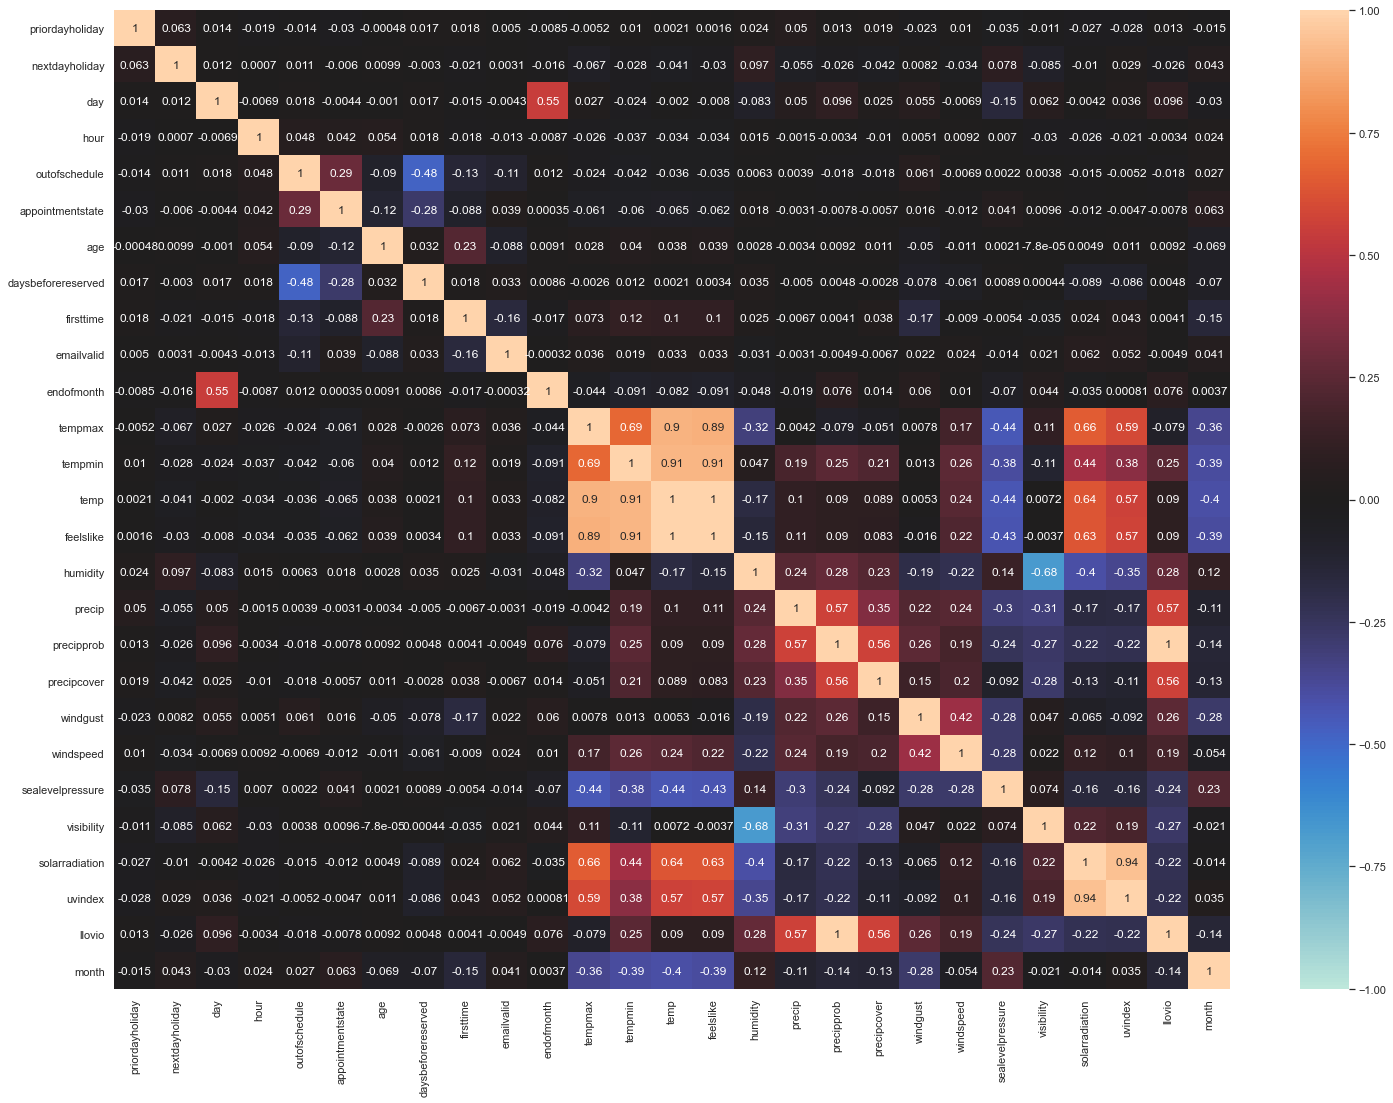

In [68]:
# visualizamos la matriz de correlación en Seaborn usando a heatmap
sns.set(rc = {'figure.figsize':(25,18)})
sns.heatmap(data_final.corr(), vmin=-1, vmax=1, center=0, annot=True);

<AxesSubplot:>

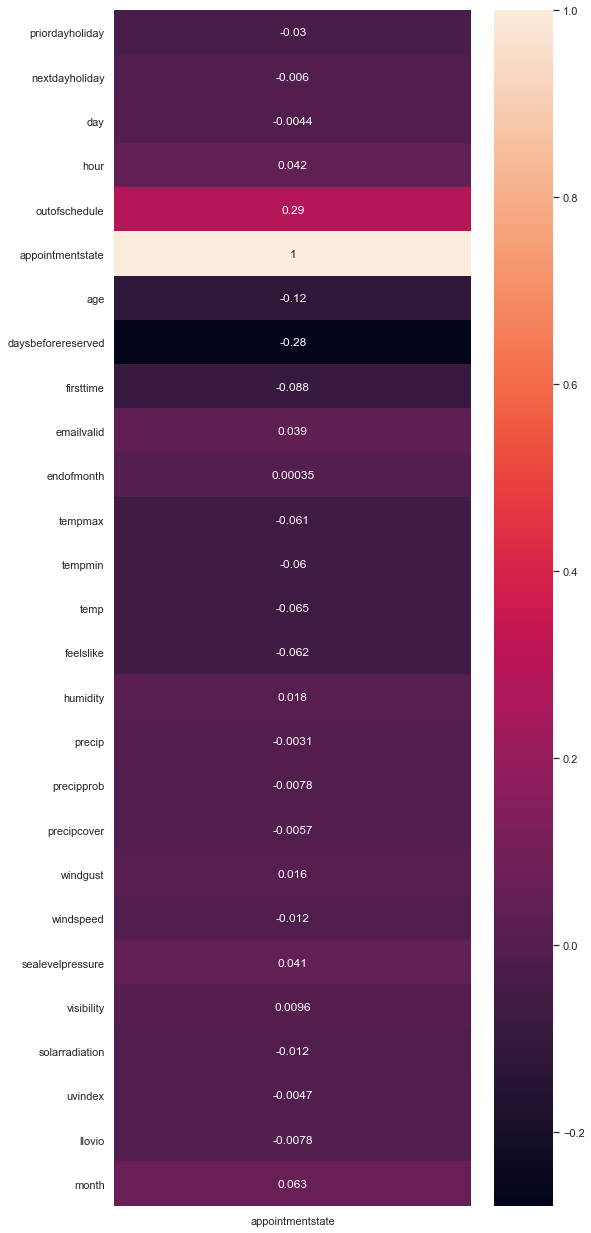

In [69]:
plt.figure(figsize=(8,22))
sns.heatmap(data_final.corr()[['appointmentstate']], annot=True)

In [70]:
data_final.to_csv("Data/dataset_turnos.csv")